In [14]:
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from datetime import date
import math
from scipy.stats import chi2_contingency 
import datetime
from dateutil.relativedelta import relativedelta as relativedelta
from iteration_utilities import deepflatten
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import io
import sys
import scipy
from numpy.linalg import norm
from scipy.signal import savgol_filter
import statsmodels.api as sm
import scipy

data_folder="./data/"

## Load data

In [2]:
data_old=pd.read_csv(data_folder+'NHS_England_Feb-2021.csv')
data_new=pd.read_csv(data_folder+'NHS_England_Feb-2022.csv')
data_new2=pd.read_csv(data_folder+'NHS_England_May-2022.csv')

data_all=pd.concat([data_new, data_old])
data_all=pd.concat([data_all, data_new2])
data_all.drop_duplicates(inplace=True)

## Define functions for processing data

In [3]:
def get_recovery_sum(data_all, dates_previous, measure): 
    recovery=[]
    non_recovery=[]
    recovery_timeline=[]
    non_recovery_timeline=[]
    for s in data_all['ORG_NAME2'].unique(): 
        data_insight_all=data_all[data_all['ORG_NAME2']==s]
        r=[]
        non_r=[]
        for d in dates_previous: 
            data_months=data_insight_all[data_insight_all['REPORTING_PERIOD_START']==d]
            try: 
                ended_treatment=int(np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']=='Count_FinishedCourseTreatment'])[0])
                percent_recovery=float(np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']==measure])[0])/100
                
                recovered=np.round(ended_treatment*percent_recovery)
                not_recovered=np.round(ended_treatment*(1-percent_recovery))
                recovery.append(recovered)
                r.append(recovered)
                non_recovery.append(not_recovered)
                non_r.append(not_recovered)
            except: 
                recovery.append(0)
                non_recovery.append(0)
                r.append(0)
                non_r.append(0)
        recovery_timeline.append(r)
        non_recovery_timeline.append(non_r)
        
    return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))



def get_recovery_rates(dates_previous, dates_after, measure, data): 
    recovery_previous, not_recovered_previous, average_number_referrals_before, timeline_recovered_before=get_recovery_sum(data, dates_previous, measure)
    if recovery_previous!=0: 
        recovery_after, not_recovered_after, average_number_referrals_after, timeline_recovered_after=get_recovery_sum(data, dates_after, measure)
    else: 
        return 0, 0, 0, 0, np.array([0,0,0,0]), 0, 0, [], []
    try: 
        p=test_for_significance(recovery_previous, not_recovered_previous, recovery_after, not_recovered_after)
        recovery_rate_before=recovery_previous/(recovery_previous+not_recovered_previous)
        recovery_rate_after=recovery_after/(recovery_after+not_recovered_after)
        recover_split=np.array([recovery_previous,not_recovered_previous,recovery_after,not_recovered_after])
        all_observation=recover_split.sum()
        return recovery_rate_before, recovery_rate_after, p, all_observation, recover_split, average_number_referrals_before, average_number_referrals_after, timeline_recovered_before, timeline_recovered_after
    except: 
        return 0, 0, 0, 0, np.array([0,0,0,0]), 0, 0, [], []

def test_for_significance(recovery_previous, not_recovered_previous, recovery_after, not_recovered_after): 
    before = [recovery_previous, not_recovered_previous] 
    after = [recovery_after, not_recovered_after] 
    table=[before, after]
    chi2, p, dof, ex = chi2_contingency(table) 
    return p

def get_referrall_rates(dates_previous, dates_after, data): 
    referrals_before, referrals_perMonth_before=get_referral_sum(data, dates_previous)
    if referrals_before!=0: 
        referrals_after, referrals_perMonth_after=get_referral_sum(data, dates_after)
    else: 
        return 0, 0, 0, 0
    return referrals_before, referrals_after, referrals_perMonth_before, referrals_perMonth_after

def get_referral_sum(data_all, dates_previous): 
    referrals=[]
    for s in data_all['ORG_NAME2'].unique(): 
        data_insight_all=data_all[data_all['ORG_NAME2']==s]
        r=[]
        non_r=[]
        for d in dates_previous: 
            data_months=data_insight_all[data_insight_all['REPORTING_PERIOD_START']==d]
            try: 
                arr=np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']=='Count_ReferralsReceived'])
                ref_months=int(arr[0])
                referrals.append(ref_months)
            except: 
                referrals.append(0)
    return  np.array(referrals).sum(), np.array(referrals).sum()/len(dates_previous)


def prepare_output_vector(results_pre_post): 
    outcome_vector=[]
    outcome_vector.append([int(1)]*int(results_pre_post[0]))
    outcome_vector.append([int(0)]*int(results_pre_post[1]))
    outcome_vector.append([int(1)]*int(results_pre_post[2]))
    outcome_vector.append([int(0)]*int(results_pre_post[3]))
    return np.array(list(deepflatten(outcome_vector)))


def prepare_pre_post(results_pre_post): 
    input_vector=[]
    input_vector.append([0]*int(results_pre_post[0]+results_pre_post[1]))
    input_vector.append([1]*int(results_pre_post[2]+results_pre_post[3]))
    return np.array(list(deepflatten(input_vector)))

def prepare_side_identifier(results_pre_post, ind): 
    return np.array([ind]*int(results_pre_post.sum()))

def prepare_initial_recover(results_pre_post, initial_recovery): 
    return np.array([initial_recovery]*int(results_pre_post.sum()))


def prepare_input_vector(results_pre_post, ind): 
    input_vector=[]
    input_vector.append(prepare_side_identifier(results_pre_post, ind))
    input_vector.append(prepare_pre_post(results_pre_post))
    return np.array(input_vector)


def get_recovery_service(input_data, months=4, measure='Percentage_ReliableRecovery'): 
    #Percentage_FirstTreatment6WeeksFinishedCourseTreatment
    #Count_ReferralsReceived
    service_ind=[]
    service=input_data['service']
    for k in data_all['ORG_NAME2']: 
        if k.lower().startswith(service): 
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all['service_index']=np.array(service_ind)
    data_service=data_all[data_all['service_index']==True]
    dt_object = datetime.datetime.strptime(input_data['start_date'],  "%d/%m/%Y")
    dt_object2 = datetime.datetime.strptime(input_data['final_date'],  "%d/%m/%Y")
    month_Minus1=dt_object  - relativedelta(months=1)
    month_Minus2=dt_object  - relativedelta(months=2)
    # today = datetime.date.today()
    diff=dt_object2-dt_object
    date_after=[dt_object  + relativedelta(months=i) for i in range(months, round(diff.days/30))]
    dates_previous=[month_Minus2.strftime("%d/%m/%Y").split(' ')[0], month_Minus1.strftime("%d/%m/%Y").split(' ')[0], dt_object.strftime("%d/%m/%Y").split(' ')[0]] #, '01/01/2021', '01/02/2021'
    dates_after_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_after]
    return get_recovery_rates(dates_previous, dates_after_string, measure, data_service)

def get_referral_service(input_data, months=4): 
    #Percentage_FirstTreatment6WeeksFinishedCourseTreatment
    #Count_ReferralsReceived
    service_ind=[]
    service=input_data['service']
    for k in data_all['ORG_NAME2']: 
        if k.lower().startswith(service): 
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all['service_index']=np.array(service_ind)
    data_service=data_all[data_all['service_index']==True]
    dt_object = datetime.datetime.strptime(input_data['start_date'],  "%d/%m/%Y")
    dt_object2 = datetime.datetime.strptime(input_data['final_date'],  "%d/%m/%Y")
    month_Minus1=dt_object  - relativedelta(months=1)
    month_Minus2=dt_object  - relativedelta(months=2)
    # today = datetime.date.today()
    diff=dt_object2-dt_object
    date_after=[dt_object  + relativedelta(months=i) for i in range(months, round(diff.days/30))]
    print(date_after)
    dates_previous=[month_Minus2.strftime("%d/%m/%Y").split(' ')[0], month_Minus1.strftime("%d/%m/%Y").split(' ')[0], dt_object.strftime("%d/%m/%Y").split(' ')[0]] #, '01/01/2021', '01/02/2021'
    dates_after_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_after]
    return get_referrall_rates(dates_previous, dates_after_string,data_service)

def get_timeline(months): 
    results_pre_post_limbic=[]
    results_pre_post_NHS=[]

    outcomes=[]
    pre_post=[]
    service_id=[]
    initial_recovery_rates=[]
    limbic_used=[]
    number_referral_initial=[]
    number_referral_final=[]
    service_code=[]
    recovery_timeline_limbic_pre=[]
    recovery_timeline_limbic_post=[]
    serviceName_pre_post_NHS=[]

    recovery_timeline_NHS_pre=[]
    recovery_timeline_NHS_post=[]
    results_raw=[]

    for i, input_data in enumerate(inputs_services): 
        output=get_recovery_service(input_data, months=months)
        results_pre_post_limbic.append([output[0], output[1]])
        outcomes.append(prepare_output_vector(output[4]))
        results_raw.append(output[4])
        service_code.append([input_data]*int(output[4].sum()))
        pre_post.append(prepare_pre_post(output[4]))
        service_id.append(prepare_side_identifier(output[4], i))
        initial_recovery_rates.append(prepare_side_identifier(output[4], output[0]))
        limbic_used.append(prepare_side_identifier(output[4], 1))
        number_referral_initial.append(prepare_side_identifier(output[4], int(output[5])))
        number_referral_final.append(prepare_side_identifier(output[4], int(output[6])))
        recovery_timeline_limbic_pre.append(output[7])
        recovery_timeline_limbic_post.append(output[8])
        

    for i, input_data in enumerate(all_services): 
        if (input_data.lower().startswith('insight')==False) & (input_data.lower().startswith('trent')==False) & (input_data.lower().startswith('vita health')==False) & (input_data.lower().startswith('surrey iapt')==False)& (input_data.lower().startswith('all providers')==False): 
            output=get_recovery_service( {'service': input_data.lower(), 'start_date': '01/12/2020', 'final_date': '01/05/2022'}, months=months)
            service_code.append([input_data]*int(output[4].sum()))
            if output[0]!=0: 
                results_pre_post_NHS.append([output[0], output[1]])
                serviceName_pre_post_NHS.append(input_data)
                results_raw.append(output[4])
            outcomes.append(prepare_output_vector(output[4]))
            pre_post.append(prepare_pre_post(output[4]))
            service_id.append(prepare_side_identifier(output[4], i))
            initial_recovery_rates.append(prepare_side_identifier(output[4], output[0]))
            limbic_used.append(prepare_side_identifier(output[4], 0))
            number_referral_initial.append(prepare_side_identifier(output[4], int(output[5])))
            number_referral_final.append(prepare_side_identifier(output[4], int(output[6])))
            recovery_timeline_NHS_pre.append(output[7])
            recovery_timeline_NHS_post.append(output[8])
        else: 
            print(input_data)



    outcomes=np.array(list(deepflatten(outcomes)))
    pre_post=np.array(list(deepflatten(pre_post)))
    service_id=np.array(list(deepflatten(service_id)))
    initial_recovery_rates=np.array(list(deepflatten(initial_recovery_rates)))
    limbic_used=np.array(list(deepflatten(limbic_used)))

    service_code=np.array(list(deepflatten(service_code)))
    number_referral_initial=np.array(list(deepflatten(number_referral_initial)))
    number_referral_final=np.array(list(deepflatten(number_referral_final)))
    results={'outcomes': outcomes, 
    'pre_post': pre_post, 
    'service_id': service_id, 
    'initial_recovery_rates': initial_recovery_rates, 
    'limbic_used': limbic_used,
    'service_code': service_code,
    'number_referral_initial': number_referral_initial,
    'number_referral_final': number_referral_final,
    'recovery_timeline_limbic_pre': recovery_timeline_limbic_pre,
    'recovery_timeline_limbic_post': recovery_timeline_limbic_post,
    'recovery_timeline_NHS_pre': recovery_timeline_NHS_pre,
    'recovery_timeline_NHS_post': recovery_timeline_NHS_post,
    'results_pre_post_NHS': results_pre_post_NHS, 
    'results_pre_post_limbic': results_pre_post_limbic, 
    'results_raw':results_raw
    }
    return results

Define services and time during which Limbic was used

In [4]:
all_services=data_all['ORG_NAME2'].unique()

input_data_insight={"service":'insight',
    'start_date':'01/11/2021',
    'final_date':'01/06/2022',
}

input_data_surrey={"service":'surrey iapt',
    'start_date':'01/07/2021',
    'final_date':'01/06/2022',
}

input_data_trent={"service":'trent',
    'start_date':'01/07/2021',
    'final_date':'01/06/2022',
}


input_data_vita={"service":'vita health',
    'start_date':'01/12/2020',
    'final_date':'01/06/2022',
}

inputs_services=[input_data_insight, input_data_trent, input_data_vita, input_data_surrey]#,  input_data_trent, input_data_vita


## Create Figure 1

In [5]:
results=get_timeline(1)

<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

all Providers


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (PETERBOROUGH)
INSIGHT HEALTHCARE TALKING THERAPIES (KENT & MEDWAY)
INSIGHT HEALTHCARE - NOTTINGHAM CITY
INSIGHT HEALTHCARE - NOTTINGHAMSHIRE
INSIGHT HEALTHCARE - DERBYSHIRE
INSIGHT HEALHTCARE TALKING THERAPIES (BASSETLAW)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))


INSIGHT HEALTHCARE MID NOTTINGHAMSHIRE
TRENT PTS
VITA HEALTH GROUP: VITA MINDS BASILDON & BRENTWOOD
VITA HEALTH GROUP: VITAMINDS BRISTOL, NORTH SOMERSET & SOUTH GLOUCESTERSHIRE
VITA HEALTH GROUP: VITAMINDS DARTFORD
VITA HEALTH GROUP: VITAMINDS DERBY
VITA HEALTH GROUP: VITAMINDS CALDERDALE


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

SURREY IAPT


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

VITA HEALTH GROUP: VITAMINDS WEST ESSEX
VITA HEALTH GROUP:VITAMINDS KENT AND MEDWAY


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (CALDERDALE)
INSIGHT HEALTHCARE TALKING THERAPIES (TEESSIDE)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (EAST RIDING OF YORKSHIRE)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

In [6]:
results_pre_post_limbic=np.array(results['results_pre_post_limbic'])
results_pre_post_NHS=np.array(results['results_pre_post_NHS'])


In [7]:
results['recovery_timeline_limbic_post'][3]=results['recovery_timeline_limbic_post'][3][np.isnan(results['recovery_timeline_limbic_post'][3])==False]

In [10]:
averages_post=[]
for i in range(17): 
    average_for_time=[]
    try: 
        average_for_time.append(results['recovery_timeline_limbic_post'][0][i])
    except: 
        i
    try: 
        average_for_time.append(results['recovery_timeline_limbic_post'][1][i])
    except: 
        i
    try: 
        average_for_time.append(results['recovery_timeline_limbic_post'][2][i])
    except: 
        i
    try: 
        average_for_time.append(results['recovery_timeline_limbic_post'][3][i])
    except: 
        i
    averages_post.append(np.array(average_for_time).mean())
averages_post=np.array(averages_post)

In [11]:
averages_post=averages_post[np.isnan(averages_post)==False]
yhat = savgol_filter(np.array(results['recovery_timeline_limbic_pre']).mean(axis=0), 3, 1)

yhat2 = savgol_filter(np.array(averages_post), 9, 1)


NameError: name 'folder_figures_save' is not defined

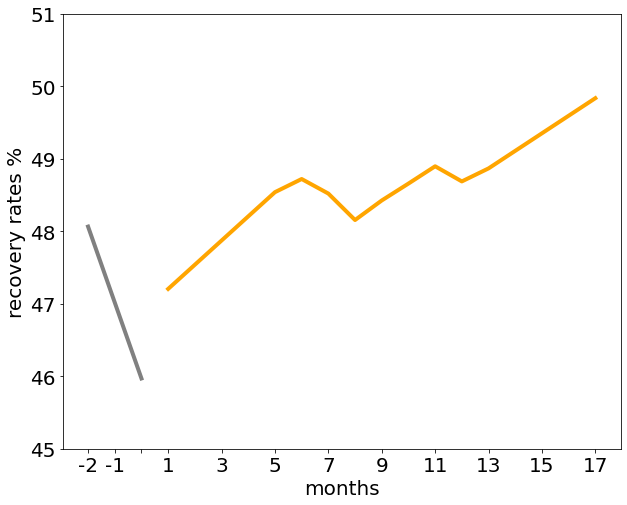

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot([-2,-1,0], yhat, linewidth=4, color='grey')
plt.plot([f+1 for f in range(len(averages_post))], yhat2, linewidth=4, color='orange')
plt.ylim(.45, .51)
plt.ylabel('recovery rates %', fontsize=20)
plt.xticks([-2, -1, 0,1, 3, 5, 7, 9, 11,13, 15, 17], ['-2', '-1', '','1','3','5', '7', '9', '11', '13', '15', '17'], fontsize=20)
plt.yticks([.45, .46, .47,.48, .49, .50, .51], ['45', '46', '47', '48', '49', '50','51'], fontsize=20)

plt.xlabel('months', fontsize=20)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = folder_figures_save+'timeline_improvement.svg'

fig.savefig(image_name, format=image_format, dpi=1200)


In [13]:
results=get_timeline(4)

<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

all Providers


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (PETERBOROUGH)
INSIGHT HEALTHCARE TALKING THERAPIES (KENT & MEDWAY)
INSIGHT HEALTHCARE - NOTTINGHAM CITY
INSIGHT HEALTHCARE - NOTTINGHAMSHIRE
INSIGHT HEALTHCARE - DERBYSHIRE
INSIGHT HEALHTCARE TALKING THERAPIES (BASSETLAW)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))


INSIGHT HEALTHCARE MID NOTTINGHAMSHIRE
TRENT PTS
VITA HEALTH GROUP: VITA MINDS BASILDON & BRENTWOOD
VITA HEALTH GROUP: VITAMINDS BRISTOL, NORTH SOMERSET & SOUTH GLOUCESTERSHIRE
VITA HEALTH GROUP: VITAMINDS DARTFORD
VITA HEALTH GROUP: VITAMINDS DERBY
VITA HEALTH GROUP: VITAMINDS CALDERDALE


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

SURREY IAPT


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

VITA HEALTH GROUP: VITAMINDS WEST ESSEX
VITA HEALTH GROUP:VITAMINDS KENT AND MEDWAY


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (CALDERDALE)
INSIGHT HEALTHCARE TALKING THERAPIES (TEESSIDE)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

INSIGHT HEALTHCARE TALKING THERAPIES (EAST RIDING OF YORKSHIRE)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

In [15]:
data=pd.DataFrame({'pre_post': results['pre_post'], 'initial_recovery':  results['initial_recovery_rates'],'outcome': results['outcomes'], 'limbic':results['limbic_used'] , 'number_referrals_pre':results['number_referral_initial'] , 'number_referrals_post':results['number_referral_final'] })
x=np.transpose(np.array([data['pre_post'], data['limbic'], data['initial_recovery'], data['number_referrals_pre'], data['number_referrals_post']-data['number_referrals_pre'], data['pre_post']*data['limbic']]))
x=sm.add_constant(x)
model = sm.Logit(data['outcome'], x).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.688692
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:               835393
Model:                          Logit   Df Residuals:                   835386
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Nov 2022   Pseudo R-squ.:                0.004854
Time:                        09:53:22   Log-Likelihood:            -5.7533e+05
converged:                       True   LL-Null:                   -5.7814e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4332      0.021    -69.719      0.000      -1.474      -1.393
x1            -0.0366      0.006     -6.132      0.000      -0.048      -0.025
x2            -0.1110      0.018     -6.261      0.000      -0.146      -0.076
x3             2.7342      0.040     68.791      0.000       2.656       2.812
x4          8.932e-05   6.24e-06     14.318      0.000    7.71e-05       0.000
x5            -0.0004   1.16e-05    -31.781      0.000      -0.000      -0.000
x6             0.2199      0.020     11.083      0.000       0.181       0.259
==============================================================================
"""

In [16]:
data=pd.DataFrame({'pre_post': results['pre_post'], 'initial_recovery':  results['initial_recovery_rates'],'outcome': results['outcomes'], 'limbic':results['limbic_used'] , 'number_referrals_pre':results['number_referral_initial'] , 'number_referrals_post':results['number_referral_final'] })
data=data[data['pre_post']==1]
x=np.transpose(np.array(data['limbic']))
x=sm.add_constant(x)
model = sm.Logit(data['outcome'], x).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.691828
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:               680519
Model:                          Logit   Df Residuals:                   680517
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Nov 2022   Pseudo R-squ.:               4.288e-05
Time:                        09:53:32   Log-Likelihood:            -4.7080e+05
converged:                       True   LL-Null:                   -4.7082e+05
Covariance Type:            nonrobust   LLR p-value:                 2.092e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1056      0.003    -42.118      0.000      -0.111      -0.101
x1             0.0635      0.010      6.356      0.000       0.044       0.083
==============================================================================
"""

## Create figure 2

In [17]:
counts_recovery=[]
for i, input_data in enumerate(inputs_services): 
    output=get_recovery_service(input_data)
    print(output)
    counts_recovery.append(output[4])
counts_recovery=np.array(counts_recovery)

(0.460253164556962, 0.4960284853464804, 0.0019561649677894747, 7601.0, array([1818., 2132., 1811., 1840.]), 1316.6666666666667, 1217.0, array([0.49958983, 0.4704413 , 0.42091503]), array([0.48389513, 0.48691589, 0.51685393]))
(0.4928635953026197, 0.48600909408884224, 0.41159552179894754, 16971.0, array([2728., 2807., 5558., 5878.]), 1845.0, 1633.7142857142858, array([0.5       , 0.48984772, 0.49017632]), array([0.48      , 0.44982935, 0.48013029, 0.49009585, 0.5       ,
       0.52026578, 0.47977528]))
(0.4492315444696397, 0.4918368956542314, 6.468572672237958e-07, 29327.0, array([ 1783.,  2186., 12472., 12886.]), 1323.0, 1811.2857142857142, array([0.43746032, 0.45367647, 0.46131528]), array([0.51372549, 0.51090116, 0.50432099, 0.49570815, 0.48235294,
       0.48321465, 0.49095745, 0.46551724, 0.44327485, 0.50875332,
       0.49552867, 0.5141828 , 0.47647059, 0.50734177]))
(0.472183908045977, 0.47025371828521434, 0.9210669193835764, 4461.0, array([1027., 1148., 1075., 1211.]), 725.0, 3

<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))


In [18]:
input_data_time={'start_date':'01/12/2020',
    'final_date':'01/06/2022',
}

In [19]:
counts_recovery_NHS=[]
for i, input_data in enumerate(all_services): 
    if (input_data.lower().startswith('insight')==False) & (input_data.lower().startswith('trent')==False) & (input_data.lower().startswith('vita health')==False) & (input_data.lower().startswith('surrey iapt')==False)& (input_data.lower().startswith('all providers')==False): 
        output=get_recovery_service( {'service': input_data.lower(), 'start_date': input_data_time['start_date'], 'final_date': input_data_time['final_date']})
    counts_recovery_NHS.append(output[4])
counts_recovery_NHS=np.array(counts_recovery_NHS)


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

In [20]:
recovery_limbic_before=counts_recovery.sum(axis=0)[0]/(counts_recovery.sum(axis=0)[0]+counts_recovery.sum(axis=0)[1])
recovery_limbic_after=counts_recovery.sum(axis=0)[2]/(counts_recovery.sum(axis=0)[2]+counts_recovery.sum(axis=0)[3])

In [21]:
chi2_contingency([[counts_recovery.sum(axis=0)[0], counts_recovery.sum(axis=0)[1]], [counts_recovery.sum(axis=0)[2], counts_recovery.sum(axis=0)[3]]])

(16.148428176321328,
 5.8567152209312676e-05,
 1,
 array([[ 7571.33461275,  8057.66538725],
        [20700.66538725, 22030.33461275]]))

In [22]:
chi2_contingency([[counts_recovery_NHS.sum(axis=0)[0], counts_recovery_NHS.sum(axis=0)[1]], [counts_recovery_NHS.sum(axis=0)[2], counts_recovery_NHS.sum(axis=0)[3]]])

(93.4602214028126,
 4.144468099938758e-22,
 1,
 array([[ 71254.89936214,  79710.10063786],
        [350896.10063786, 392533.89936214]]))

In [23]:
recovery_limbic_before=counts_recovery.sum(axis=0)[0]/(counts_recovery.sum(axis=0)[0]+counts_recovery.sum(axis=0)[1])
recovery_limbic_after=counts_recovery.sum(axis=0)[2]/(counts_recovery.sum(axis=0)[2]+counts_recovery.sum(axis=0)[3])

In [24]:
recovery_NHS_before=counts_recovery_NHS.sum(axis=0)[0]/(counts_recovery_NHS.sum(axis=0)[0]+counts_recovery_NHS.sum(axis=0)[1])
recovery_NHS_after=counts_recovery_NHS.sum(axis=0)[2]/(counts_recovery_NHS.sum(axis=0)[2]+counts_recovery_NHS.sum(axis=0)[3])

In [25]:
import matplotlib.pyplot as plt
error_Limbic=[results_pre_post_limbic.std(axis=0)[0]/math.sqrt(len(results_pre_post_limbic)), results_pre_post_limbic.std(axis=0)[1]/math.sqrt(len(results_pre_post_limbic))]
error_NHS=[results_pre_post_NHS.std(axis=0)[0]/math.sqrt(len(results_pre_post_NHS)), results_pre_post_NHS.std(axis=0)[1]/math.sqrt(len(results_pre_post_NHS))]

([<matplotlib.axis.YTick at 0x25100bc4610>,
 [Text(0, 0.4, '40'),
  Text(0, 0.42, '42'),
  Text(0, 0.44, '44'),
  Text(0, 0.46, '46'),
  Text(0, 0.48, '48'),
  Text(0, 0.5, '50')])

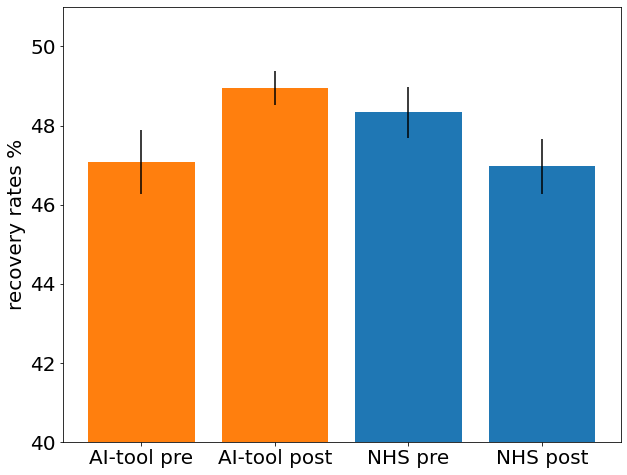

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))

plt.bar([2,3], [recovery_NHS_before, recovery_NHS_after],yerr=error_NHS)
plt.bar([0,1], [recovery_limbic_before, recovery_limbic_after],yerr=error_Limbic)

# plt.ylim([.4, .5])
# plt.ylabel('recovery rates %', fontsize=20)

plt.xticks([0,1,2,3], ['AI-tool pre', 'AI-tool post', 'NHS pre', 'NHS post'], fontsize=20)

plt.ylim(.45, .51)
plt.ylabel('recovery rates %', fontsize=20)
plt.yticks([.4, .42, .44,.46, .48, .50], ['40','42', '44', '46', '48', '50'], fontsize=20)


# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'interaction.svg'

# fig.savefig(image_name, format=image_format, dpi=1200)


# image_format = 'png' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'Figure2.png'
# fig.savefig(image_name, format=image_format, dpi=1200)


## Define comparison group

In [46]:

percentag_IAPT=50 # 1=most similar IAPT service, 25=25% of NHS most similar IAPT service, 50=50% of NHS most similar IAPT services

## Sample similar IAPT services

In [47]:

text_trap = io.StringIO()
sys.stdout = text_trap



service_compare=[]
distance_compare=[]
direction_compare=[]
output2=[]
for i, input_data_limbic in enumerate(inputs_services): 
    vector_comparison=[]
    service_id=[]
    output=get_recovery_service(input_data_limbic)
    output2=get_referral_service(input_data_limbic)
    initial_recovery=output[0]
    pre_numbers_treatment=output[4][0]+output[4][1]
    post_numbers_treatment=output[4][2]+output[4][3]
    try: 
        change=(post_numbers_treatment-pre_numbers_treatment)/(pre_numbers_treatment+pre_numbers_treatment)
        change_referral=(output2[3]-output2[2])/(output2[2]+output2[3])
    except: 
        change=0
        change_referral=0

    service_id.append(input_data_limbic['service'])
    vector_comparison.append([initial_recovery, change, change_referral])


    for i, input_data in enumerate(all_services): 
        if (input_data.lower().startswith('insight')==False) & (input_data.lower().startswith('trent')==False) & (input_data.lower().startswith('vita health')==False) & (input_data.lower().startswith('surrey iapt')==False)& (input_data.lower().startswith('all providers')==False): 
            output=get_recovery_service( {'service': input_data.lower(), 'start_date': input_data_limbic['start_date'], 'final_date': input_data_limbic['final_date']})
            output2=get_referral_service( {'service': input_data.lower(), 'start_date': input_data_limbic['start_date'], 'final_date': input_data_limbic['final_date']})

            initial_recovery=output[0]
            if initial_recovery!=0: 
                pre_numbers_treatment=int(output[4][0]+output[4][1])
                post_numbers_treatment=int(output[4][2]+output[4][3])
                try: 
                    change=(post_numbers_treatment-pre_numbers_treatment)/(pre_numbers_treatment+pre_numbers_treatment)
                    change_referral=(output2[3]-output2[2])/(output2[2]+output2[3])
                except: 
                    change=0
                service_id.append(input_data)
                vector_comparison.append([initial_recovery, change, change_referral])

        else: 
            print(input_data)
    vector_comparison=np.array(vector_comparison)

    normalised_vector_comparison=scipy.stats.zscore(vector_comparison, axis=0)
    normalised_vector_comparison[:,0]=normalised_vector_comparison[:,0]

    distance=[]
    service=[]
    input_matrix=[]
    for i in range(normalised_vector_comparison.shape[0]): 
        # distance.append(cdist(vector_comparison[0, :2],vector_comparison[i, :2],'mahalanobis'))
        distance.append(norm(normalised_vector_comparison[0, :2]-normalised_vector_comparison[i, :2]))

        
        # distance.append(norm(vector_comparison[0, 0]-vector_comparison[:, 0]))
        service.append(service_id[i])
        input_matrix.append(vector_comparison[i, :])
    sorted_distance=pd.DataFrame({'service': service, 'distance':distance, 'input_matrix':input_matrix,
    'direction':vector_comparison[0, 0]-vector_comparison[:, 0], 
    'initial_recovery':vector_comparison[:, 0], 
    'change_treatment':  vector_comparison[:, 1], 
    'change_referrals': vector_comparison[:, 2]
     })
    sorted_distance=sorted_distance.sort_values(by='distance')
    if percentag_IAPT==50: 
        service_include=[sorted_distance['service'][sorted_distance['direction']>0].iloc[:46], sorted_distance['service'][sorted_distance['direction']<0].iloc[:46]]
        distance_include=[sorted_distance['distance'][sorted_distance['direction']>0].iloc[:46], sorted_distance['distance'][sorted_distance['direction']<0].iloc[:46]]
        direction_include=[sorted_distance['direction'][sorted_distance['direction']>0].iloc[:46], sorted_distance['direction'][sorted_distance['direction']<0].iloc[:46]]
    elif percentag_IAPT==25:
        service_include=[sorted_distance['service'][sorted_distance['direction']>0].iloc[:23], sorted_distance['service'][sorted_distance['direction']<0].iloc[:23]]
        distance_include=[sorted_distance['distance'][sorted_distance['direction']>0].iloc[:23], sorted_distance['distance'][sorted_distance['direction']<0].iloc[:23]]
        direction_include=[sorted_distance['direction'][sorted_distance['direction']>0].iloc[:23], sorted_distance['direction'][sorted_distance['direction']<0].iloc[:23]] 
    elif percentag_IAPT==1:
        service_include=[sorted_distance['service'].iloc[1]]
        distance_include=[sorted_distance['distance'].iloc[1]]
        direction_include=[sorted_distance['direction'].iloc[1]]
    if percentag_IAPT==1:
        s_i=service_include
        d_i=distance_include
        dir_i=direction_include
    else: 
        s_i=[]
        for vec in service_include: 
            for serv in vec: 
                s_i.append(serv)
        d_i=[]
        for vec in distance_include: 
            for d in vec: 
                d_i.append(d)
        dir_i=[]
        for vec in direction_include: 
            for d in vec: 
                dir_i.append(d)
    service_compare.append(s_i)
    distance_compare.append(d_i)
    direction_compare.append(dir_i)


sys.stdout = sys.__stdout__


<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

In [48]:
import statsmodels.api as sm
import scipy

t_value_distribution=[]
pre_NHS=[]
pre_Limbic=[]
NHS_referral=[]
Limbic_referral=[]
NHS_referral_change=[]
Limbic_referral_change=[]

for permutations in range(1):
    results_pre_post_limbic=[]
    results_pre_post_NHS=[]

    recovery_pre=[]
    outcomes=[]
    pre_post=[]
    service_id=[]
    initial_recovery_rates=[]
    limbic_used=[]
    number_treatment_initial=[]
    number_treatment_final=[]
    waittime_limbic=[]
    waittime_NHS=[]
    waittime_diff=[]
    service_code=[]
    recovery_timeline_limbic_pre=[]
    recovery_timeline_limbic_post=[]
    serviceName_pre_post_NHS=[]

    recovery_timeline_NHS_pre=[]
    recovery_timeline_NHS_post=[]
    used_comaprison=[]
    output2=[]
    referral_pre=[]
    referral_post=[]
    NHS_treatment_change=[]
    Limbic_treatment_change=[]



    for i, input_data in enumerate(inputs_services): 
        
        output=get_recovery_service(input_data)
        output2=get_referral_service(input_data)
        results_pre_post_limbic.append([output[0], output[1]])
        outcomes.append(prepare_output_vector(output[4]))
        service_code.append([input_data]*int(output[4].sum()))
        pre_post.append(prepare_pre_post(output[4]))
        service_id.append(prepare_side_identifier(output[4],i))
        initial_recovery_rates.append(prepare_side_identifier(output[4], output[0]))
        limbic_used.append(prepare_side_identifier(output[4], 1))
        number_treatment_initial.append(prepare_side_identifier(output[4], int(output[5])))
        number_treatment_final.append(prepare_side_identifier(output[4], int(output[6])))
        recovery_timeline_limbic_pre.append(output[7])
        recovery_timeline_limbic_post.append(output[8])
        referral_pre.append(prepare_side_identifier(output[4], int(output2[2])))
        referral_post.append(prepare_side_identifier(output[4], int(output2[3])))
    
        # prob=np.array(1/np.array(distance_compare[i][:]))
        # prob=prob/prob.sum()
        # input_data2 =np.random.choice(service_compare[i][:],12,  p=prob)#,  p=prob
        input_data2=service_compare[i]
        for input_data in input_data2:
            # while input_data in set(used_comaprison): 
            #     input_data =np.random.choice(service_compare[i][:],  p=prob) #, p=prob
            used_comaprison.append(input_data)
            output=get_recovery_service( {'service': input_data.lower(), 'start_date': input_data_limbic['start_date'], 'final_date': input_data_limbic['final_date']})
            output2=get_referral_service( {'service': input_data.lower(), 'start_date': input_data_limbic['start_date'], 'final_date': input_data_limbic['final_date']})
            service_code.append([input_data]*int(output[4].sum()))
            if output[0]!=0: 
                results_pre_post_NHS.append([output[0], output[1]])
            serviceName_pre_post_NHS.append(input_data)
            outcomes.append(prepare_output_vector(output[4]))
            pre_post.append(prepare_pre_post(output[4]))
            service_id.append(prepare_side_identifier(output[4], i+4))
            initial_recovery_rates.append(prepare_side_identifier(output[4], output[0]))
            limbic_used.append(prepare_side_identifier(output[4], 0))
            number_treatment_initial.append(prepare_side_identifier(output[4], int(output[5])))
            number_treatment_final.append(prepare_side_identifier(output[4], int(output[6])))
            recovery_timeline_NHS_pre.append(output[7])
            recovery_timeline_NHS_post.append(output[8])
            referral_pre.append(prepare_side_identifier(output[4], int(output2[2])))
            referral_post.append(prepare_side_identifier(output[4], int(output2[3])))


    outcomes=np.array(list(deepflatten(outcomes)))
    pre_post=np.array(list(deepflatten(pre_post)))
    service_id=np.array(list(deepflatten(service_id)))
    initial_recovery_rates=np.array(list(deepflatten(initial_recovery_rates)))
    limbic_used=np.array(list(deepflatten(limbic_used)))

    service_code=np.array(list(deepflatten(service_code)))
    number_treatment_initial=np.array(list(deepflatten(number_treatment_initial)))
    number_treatment_final=np.array(list(deepflatten(number_treatment_final)))
    referral_pre=np.array(list(deepflatten(referral_pre)))
    referral_post=np.array(list(deepflatten(referral_post)))

    data=pd.DataFrame({'pre_post': pre_post, 'initial_recovery': initial_recovery_rates, 'service': service_id, 'outcome': outcomes,
     'limbic': limbic_used, 'number_referrals_pre': referral_pre, 'number_referrals_post': referral_post, 
     'number_treat_pre': number_treatment_initial, 'number_treat_post': number_treatment_final})

    # x=np.concatenate((np.transpose(np.array([data['pre_post'], data['limbic'], data['pre_post']*data['limbic']])), categorical_service), axis=1)
    x=np.transpose(np.array([data['pre_post'], data['limbic'], 
    data['pre_post']*data['limbic'], 
    data['initial_recovery'],
    data['number_treat_post']-data['number_treat_pre']
     ]))
    x=sm.add_constant(x)
    model = sm.Logit(data['outcome'], x).fit()
    model.summary()
    t_value_distribution.append(model.tvalues[3])
    pre_NHS.append(data['outcome'][(data['pre_post']==0)&(data['limbic']==0)].mean())
    pre_Limbic.append(data['outcome'][(data['pre_post']==0)&(data['limbic']==1)].mean())
    NHS_referral.append(np.array(data['number_referrals_pre'][data['limbic']==0].unique()).mean())
    Limbic_referral.append(np.array(data['number_referrals_pre'][data['limbic']==1].unique()).mean())
    NHS_referral_change.append((np.array(data['number_referrals_post'][data['limbic']==0].unique()).mean()-np.array(data['number_referrals_pre'][data['limbic']==0].unique()).mean())/np.array(data['number_referrals_pre'][data['limbic']==0].unique()).mean())
    Limbic_referral_change.append((np.array(data['number_referrals_post'][data['limbic']==1].unique()).mean()-np.array(data['number_referrals_pre'][data['limbic']==1].unique()).mean())/np.array(data['number_referrals_pre'][data['limbic']==1].unique()).mean())
    NHS_treatment_change.append((np.array(data['number_treat_post'][data['limbic']==0].unique()).mean()-np.array(data['number_treat_pre'][data['limbic']==0].unique()).mean())/(np.array(data['number_treat_pre'][data['limbic']==1].unique()).mean()+np.array(data['number_treat_post'][data['limbic']==1].unique()).mean()))
    Limbic_treatment_change.append((np.array(data['number_treat_post'][data['limbic']==1].unique()).mean()-np.array(data['number_treat_pre'][data['limbic']==1].unique()).mean())/(np.array(data['number_treat_pre'][data['limbic']==1].unique()).mean()+np.array(data['number_treat_post'][data['limbic']==1].unique()).mean()))



<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np.array(recovery_timeline).sum(axis=0)+np.array(non_recovery_timeline).sum(axis=0))
<ipython-input-3-c3d80b019509>:30: RuntimeWarning: invalid value encountered in true_divide
  return  np.array(recovery).sum(), np.array(non_recovery).sum(), (np.array(recovery).sum()+np.array(non_recovery).sum())/len(dates_previous), np.array(recovery_timeline).sum(axis=0)/(np

In [49]:
results_pre_post_NHS

[[0.47368421052631576, 0.47613636363636364],
 [0.4856175972927242, 0.46509671993271656],
 [0.45871559633027525, 0.43670588235294117],
 [0.46, 0.4379446640316206],
 [0.4895833333333333, 0.4791859389454209],
 [0.4441717791411043, 0.4314516129032258],
 [0.48048780487804876, 0.43783783783783786],
 [0.4203125, 0.47474747474747475],
 [0.4696132596685083, 0.45849056603773586],
 [0.47258064516129034, 0.42714865363334564],
 [0.47304347826086957, 0.48045112781954885],
 [0.5121212121212121, 0.4523560209424084],
 [0.4597069597069597, 0.4476661951909477],
 [0.49167733674775926, 0.4591743119266055],
 [0.4464500601684717, 0.3981042654028436],
 [0.4460634547591069, 0.40964265456608057],
 [0.4604938271604938, 0.4647452393206382],
 [0.46106194690265484, 0.4573673870333988],
 [0.4738351254480287, 0.4504792332268371],
 [0.4530120481927711, 0.4067796610169492],
 [0.3931034482758621, 0.4711864406779661],
 [0.4524590163934426, 0.4180662732637313],
 [0.4258823529411765, 0.4640776699029126],
 [0.48480243161094

In [50]:
x=np.transpose(np.array([data['pre_post'], data['limbic'], 
data['pre_post']*data['limbic'], 
(data['number_treat_post']-data['number_treat_pre'])/data['number_treat_pre'], 
data['initial_recovery']
 ]))
x=sm.add_constant(x)
model = sm.Logit(data['outcome'], x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1528424
Model:                          Logit   Df Residuals:                  1528418
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Nov 2022   Pseudo R-squ.:                0.003498
Time:                        10:12:36   Log-Likelihood:            -1.0532e+06
converged:                       True   LL-Null:                   -1.0569e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8157      0.021    -85.747      0.000      -1.857      -1.774
x1            -0.0572      0.004    -15.957      0.000      -0.064      -0.050
x2            -0.0036      0.016     -0.223      0.823      -0.036       0.028
x3             0.1602      0.019      8.399      0.000       0.123       0.198
x4            -0.0006      0.003     -0.205      0.837      -0.006       0.005
x5             3.6156      0.044     83.026      0.000       3.530       3.701
==============================================================================
"""

In [51]:
recovery_NHS_before=np.array(results_pre_post_NHS).mean(axis=0)[0]
recovery_NHS_after=np.array(results_pre_post_NHS).mean(axis=0)[1]
error_NHS=np.array(results_pre_post_NHS).std(axis=0)/math.sqrt(len(results_pre_post_limbic))


([<matplotlib.axis.YTick at 0x2510128dc10>,
 [Text(0, 0.4, '40'),
  Text(0, 0.42, '42'),
  Text(0, 0.44, '44'),
  Text(0, 0.46, '46'),
  Text(0, 0.48, '48'),
  Text(0, 0.5, '50')])

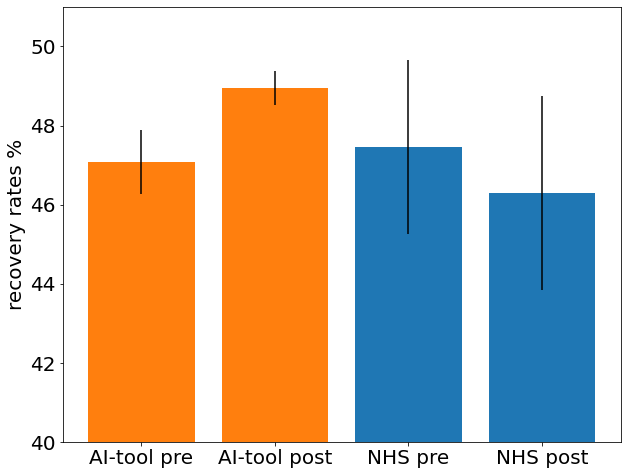

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.bar([2,3], [recovery_NHS_before, recovery_NHS_after],yerr=error_NHS)
plt.bar([0,1], [recovery_limbic_before, recovery_limbic_after],yerr=error_Limbic)


plt.xticks([0,1,2,3], ['AI-tool pre', 'AI-tool post', 'NHS pre', 'NHS post'], fontsize=20)

plt.ylim(.45, .51)
plt.ylabel('recovery rates %', fontsize=20)
plt.yticks([.4, .42, .44,.46, .48, .50], ['40','42', '44', '46', '48', '50'], fontsize=20)


# image_format = 'svg' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'25comparison_group.svg'

# fig.savefig(image_name, format=image_format, dpi=1200)


## Conduct economic analysis


In [53]:
improvements_limbic=(recovery_NHS_before-recovery_NHS_after)+(recovery_limbic_after-recovery_limbic_before)
number_improved_referrals=round((counts_recovery[:, 2:].sum())*(improvements_limbic))#
number_referred_patients=27029
price_point=[5, 7.5, 10]


In [54]:
price_overall=[]
price_per_recovery=[]
for p in price_point: 
    price_overall.append(number_referred_patients*p)
    price_per_recovery.append((number_referred_patients*p)/number_improved_referrals)
cost_Limbic=pd.DataFrame({'price per referral': price_point, 'price overall': price_overall, 'price per additional recovery': price_per_recovery})
cost_Limbic

,price per referral,price overall,price per additional recovery
0,5.0,135145.0,103.638804
1,7.5,202717.5,155.458206
2,10.0,270290.0,207.277607


### Comparison to alternatives to improve recoveries

In [65]:
cost_single_IAPT_session_low_intensity=102.38 # Griffith & Steen 
cost_single_IAPT_session_high_intensity=173.88 #  Griffith & Steen 
odds_ratio_session=math.exp(0.186) #Gyian et al show that an additional session has the a beta = .186 on recovery rates
percentage_improved_session=(odds_ratio_session*recovery_limbic_before)/(1+(odds_ratio_session*recovery_limbic_before)-recovery_limbic_before)
number_improved_session=round((counts_recovery.sum())*((percentage_improved_session)-(recovery_limbic_before)))
total_cost_session=round(number_referred_patients*cost_single_IAPT_session_low_intensity)

cost_per_recovery_session=round((number_referred_patients*cost_single_IAPT_session_low_intensity)/number_improved_session)
cost_per_recovery_session

1021